# RESNETS

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras import layers
from keras.layers import Input,Add,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D,AveragePooling2D,MaxPooling2D
from keras.models import Model,load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [3]:
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc

In [4]:
data_path=os.listdir('Downloads/expression_set/images/train')
expressions=os.listdir('Downloads/expression_set/images/train')
print(expressions)

['happy', 'angry', 'neutral', 'fear', 'disgust', 'surprise', 'sad']


In [5]:
labels=[]
emotions=[]
for i in expressions:
    emotional_exp=os.listdir('Downloads/expression_set/images/train/'+i)
    for img in emotional_exp:
        emotions.append((i,'Downloads/expression_set/images/train/'+i+'/'+str(img)))
        labels.append(i)

In [6]:
len(emotions)==len(labels)

True

In [7]:
df=pd.DataFrame(data=emotions,columns=['emotion','image'])
df.head()

,emotion,image
0,happy,Downloads/expression_set/images/train/happy/24...
1,happy,Downloads/expression_set/images/train/happy/74...
2,happy,Downloads/expression_set/images/train/happy/23...
3,happy,Downloads/expression_set/images/train/happy/18...
4,happy,Downloads/expression_set/images/train/happy/41...


In [8]:
df['emotion'].value_counts()

happy       7164
neutral     4982
sad         4938
fear        4103
angry       3993
surprise    3205
disgust      436
Name: emotion, dtype: int64

In [9]:
path="Downloads/expression_set/images/train/"
im_size=48
images=[]
labels1=[]
for i in expressions:
    data_path=path+str(i)
    filename=[i for i in os.listdir(data_path)]
    for f in filename:
        img=cv2.imread(data_path+'/'+f)
        img=cv2.resize(img,(48,48))
        images.append(img)
        labels1.append(i)

In [10]:
images=np.array(images)
images.shape

(28821, 48, 48, 3)

In [11]:
images=images.astype('float32')/255.0

In [12]:
y_label=LabelEncoder()
y=df['emotion'].values
y=y_label.fit_transform(y)
y=y.reshape(-1,1)
one_hot=OneHotEncoder()
y=one_hot.fit_transform(y)
print(y.shape)

(28821, 7)


In [38]:
images,y=shuffle(images,y)
train_x,test_x,train_y,test_y=train_test_split(images,y,test_size=0.3)

In [14]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(20174, 48, 48, 3)
(8647, 48, 48, 3)
(20174, 7)
(8647, 7)


In [15]:
def identity_block(X,f,filters):
    
    F1,F2,F3=filters
    
    X_shortcut=X
    
    X=Conv2D(filters=F1,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer = glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3)(X)
    
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    
    return X

In [16]:
def convolutional_block(X,f,filters,s=2):
    
    F1,F2,F3=filters
    
    X_shortcut=X
    
    X=Conv2D(filters=F1, kernel_size=(1,1),strides=(s,s),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F2, kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer = glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    
    X=Conv2D(filters=F3,kernel_size=(1,1),strides=(1,1),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3)(X)
    
    X_shortcut=Conv2D(filters=F3,kernel_size=(1,1),strides=(s,s),padding='valid',kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut=BatchNormalization(axis=3)(X_shortcut)
    
    X=Add()([X,X_shortcut])
    X=Activation('relu')(X)
    
    return X

In [17]:
def ResNet50(input_shape=(48,48,3),classes=7):
    
    X_input=Input(input_shape)
    
    X=ZeroPadding2D((3,3))(X_input)
    
    X=Conv2D(64,(7,7),strides=(2,2),kernel_initializer = glorot_uniform(seed=0))(X)
    X=BatchNormalization(axis=3)(X)
    X=Activation('relu')(X)
    X=MaxPooling2D((3,3),strides=(2,2))(X)
    
    X=convolutional_block(X,f=3,filters=[64,64,256],s=1)
    X=identity_block(X,3,[64,64,256])
    X=identity_block(X,3,[64,64,256])   
    
    X=convolutional_block(X,f=3,filters=[128,128,512],s=2)
    X=identity_block(X,3,[128,128,512])
    X=identity_block(X,3,[128,128,512])
    X=identity_block(X,3,[128,128,512])
    
    X=convolutional_block(X,f=3,filters=[256,256,1024],s=2)
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    X=identity_block(X,3,[256,256,1024])
    
    X=convolutional_block(X,f=3,filters=[512,512,2048],s=2)
    X=identity_block(X,3,[512,512,2048])
    X=identity_block(X,3,[512,512,2048])
    
    X=AveragePooling2D()(X)
    
    X=Flatten()(X)
    X=Dense(classes,activation='softmax',name='fc'+str(classes),kernel_initializer= glorot_uniform(seed=0))(X)
    
    model=Model(inputs=X_input,outputs=X,name='Resnet50')
    
    
    return model

In [18]:
model=ResNet50(input_shape=(48,48,3),classes=7)

In [19]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [21]:
model.fit(train_x,train_y,epochs=20,batch_size=32)
Resnet_model=model.to_json()
with open('Resnet_model','w') as json_file:
    json_file.write(Resnet_model)
model.save_weights('Resnet_model.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
20174/20174 [==============================] - 838s 42ms/step - loss: 2.4571 - acc: 0.2126
Epoch 2/20
20174/20174 [==============================] - 843s 42ms/step - loss: 2.3050 - acc: 0.2285
Epoch 3/20
20174/20174 [==============================] - 838s 42ms/step - loss: 2.2830 - acc: 0.2230
Epoch 4/20
20174/20174 [==============================] - 1028s 51ms/step - loss: 2.1232 - acc: 0.2247
Epoch 5/20
20174/20174 [==============================] - 944s 47ms/step - loss: 1.8768 - acc: 0.2403
Epoch 6/20
20174/20174 [==============================] - 1014s 50ms/step - loss: 1.8464 - acc: 0.2434
Epoch 7/20
20174/20174 [==============================] - 883s 44ms/step - loss: 1.8157 - acc: 0.2475
Epoch 8/20
20174/20174 [==============================] - 842s 42ms/step - loss: 1.7939 - acc: 0.2482
Epoch 9/20
20174/20174 [==============================] - 821s 41ms/step - loss: 1.7852 

In [22]:
preds=model.evaluate(test_x,test_y)

8647/8647 [==============================] - 31s 4ms/step


In [30]:
print("loss: ",preds[0])
print("Accuracy: ",preds[1])

loss:  1.4681251420579895
Accuracy:  0.42604371459343204


In [35]:
img_path='Downloads/expression_set/images/validation/sad/800.jpg' #testing with a sample image from the dataset
img=image.load_img(img_path,target_size=(48,48))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=preprocess_input(x)
print(model.predict(x))

[[0. 0. 0. 0. 0. 0. 1.]]


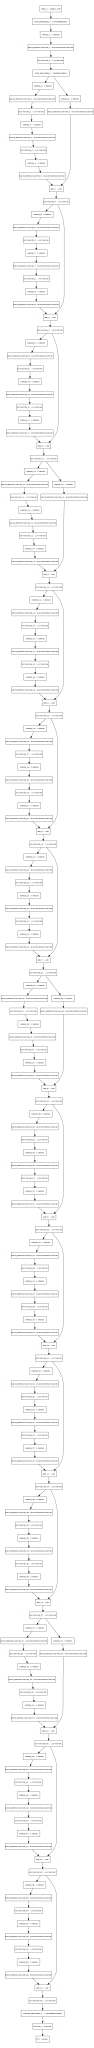

In [37]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))